In [51]:
# Install required packages (run once)
# !pip install numpy pandas matplotlib seaborn scikit-learn joblib astropy scipy tensorflow lightkurve shap streamlit tenacity --quiet

In [52]:
# Importing Libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn for splitting, metrics, and class weights
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve, 
    auc, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
import joblib

# Tensorflow/Keras for the CNN model
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Seeds for reproducibility 
tf.random.set_seed(42)
np.random.seed(42)

In [53]:
# Load or Fetch Kepler KOI Data
FILE_NAME = "kepler_koi_clean.csv"
df = None

if os.path.exists(FILE_NAME):
    print(f"Loading KOI data from existing file: {FILE_NAME}")
    try:
        df = pd.read_csv(FILE_NAME)
        print("Data loaded successfully from local drive.")
    except Exception as e:
        print(f"Error reading local file: {e}. Attempting to re-download...")
        df = None

if df is None:
    print("Local file not found or corrupted. Fetching Kepler KOI data from NASA (5+ minutes)...")
    try:
        from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
        koi_table = NasaExoplanetArchive.query_criteria(
            table="cumulative",
            select="*"
        )
        df = koi_table.to_pandas()
        df.to_csv(FILE_NAME, index=False)
        print(f"Data successfully fetched and saved as {FILE_NAME}")
    except Exception as e:
        print("Error fetching KOI data from NASA:", e)
        df = None

if df is not None:
    print(f"\nFinal Dataset Shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nValue counts for disposition:")
    print(df['koi_disposition'].value_counts())
else:
    raise FileNotFoundError("FATAL ERROR: Could not load data from local file or NASA server.")

Loading KOI data from existing file: kepler_koi_clean.csv
Data loaded successfully from local drive.

Final Dataset Shape: (9564, 155)

First 5 rows:
      kepid kepoi_name   kepler_name         ra  ra_err        ra_str  \
0  10797460  K00752.01  Kepler-227 b  291.93423     0.0  19h27m44.22s   
1  10797460  K00752.02  Kepler-227 c  291.93423     0.0  19h27m44.22s   
2  10811496  K00753.01           NaN  297.00482     0.0  19h48m01.16s   
3  10848459  K00754.01           NaN  285.53461     0.0  19h02m08.31s   
4  10854555  K00755.01  Kepler-664 b  288.75488     0.0  19h15m01.17s   

         dec  dec_err       dec_str  koi_gmag  ...  koi_insol  koi_insol_err1  \
0  48.141651      0.0  +48d08m29.9s    15.890  ...      93.59           29.45   
1  48.141651      0.0  +48d08m29.9s    15.890  ...       9.11            2.87   
2  48.134129      0.0  +48d08m02.9s    15.943  ...      39.30           31.04   
3  48.285210      0.0  +48d17m06.8s    16.100  ...     891.96          668.95   
4  48.

In [54]:
#Parameters and Configuration

#Data Processing Parameters (Consistent with process_data.py)
CACHE_DIR = './kepler_cache'
os.environ['LIGHTKURVE_CACHE_DIR'] = CACHE_DIR
print(f"Set LIGHTKURVE_CACHE_DIR to: {CACHE_DIR}")

N_SAMPLES_PER_CLASS = 1500
N_BINS = 400      # Length of the binned light curve array
MAX_LEN = N_BINS  # Consistent length variable
OUTPUT_FILE = 'processed_data_output.pkl' 
LOG_FILE = './parallel_processing_script.log' 

# Model Training Parameters 
BATCH_SIZE = 16
EPOCHS = 25
MODEL_NAME = 'exoplanet_cnn_model.keras'

Set LIGHTKURVE_CACHE_DIR to: ./kepler_cache


In [55]:
# Execute the Data Processing Script

print("-----------------------------------------------------------------")
print("Starting external data processing script (using ThreadPoolExecutor).")
print(f"Details and progress are logged to: {LOG_FILE}")
print("-----------------------------------------------------------------")

# Run the external script
# NOTE: To test quickly, change the line below to: !python process_data.py --use-mock
!python process_data.py --use-mock

-----------------------------------------------------------------
Starting external data processing script (using ThreadPoolExecutor).
Details and progress are logged to: ./parallel_processing_script.log
-----------------------------------------------------------------
2025-10-29 19:10:47,072 - INFO - --- Starting parallel data processing script ---
2025-10-29 19:10:47,072 - INFO - Script run with use_mock=True
2025-10-29 19:10:47,179 - INFO - Loaded input CSV with shape (9564, 155)
2025-10-29 19:10:47,202 - INFO - Sampled 1500 confirmed and 1500 false positives for processing.
2025-10-29 19:10:47,213 - INFO - Starting parallel processing with 8 workers...
2025-10-29 19:10:47,213 - INFO - Clearing old cache directory: ./kepler_cache
2025-10-29 19:10:47,226 - INFO - Cache directory ready.
2025-10-29 19:10:47,227 - INFO - Processing KIC 12069319: period=231.157554, epoch=346.94896
2025-10-29 19:10:47,228 - INFO - Processing KIC 8321314: period=15.03366411, epoch=144.98055
2025-10-29 19:1

In [56]:
#Load Processed Data

OUTPUT_FILE = 'processed_data_output.pkl' # Ensuring this matches my parameter cell

import joblib

try:
    # Load the saved tuple (X_arr, y_arr) from the disk file
    X_arr, y_arr = joblib.load(OUTPUT_FILE)
    print(f"Data successfully loaded from {OUTPUT_FILE}.")
    print(f"Feature array shape (X_arr): {X_arr.shape}")
    print(f"Label array shape (y_arr): {y_arr.shape}")
    
    # Integrity check
    if X_arr.size == 0:
        print("WARNING: X_arr is empty. The data processing script likely failed to fetch any light curves.")
        
except FileNotFoundError:
    print(f"FATAL ERROR: File '{OUTPUT_FILE}' not found. Please ensure Cell 16 completed successfully.")
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")

Data successfully loaded from processed_data_output.pkl.
Feature array shape (X_arr): (3000, 400, 1)
Label array shape (y_arr): (3000,)


In [57]:
# Train/Test Split and Class Weights
X_train, X_test, y_train, y_test = train_test_split(X_arr, y_arr, test_size=0.2, stratify=y_arr, random_state=42)
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, class_weights)}
print('Class Weights:', class_weight_dict)

Class Weights: {0: 1.0, 1: 1.0}


In [58]:
# 1D CNN Definition
def build_cnn(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, 9, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(64, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

model = build_cnn((N_BINS, 1))
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 400, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 400, 32)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 400, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 400, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 200, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 200, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,145 (336.50 KB)

 Trainable params: 85,441 (333.75 KB)

 Non-trainable params: 704 (2.75 KB)

In [59]:
# Training with Callbacks
cb = [
    callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max'),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    callbacks.ModelCheckpoint('best_cnn_kepler.keras', monitor='val_auc', save_best_only=True, mode='max')
]
history = model.fit(X_train, y_train, validation_split=0.15, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    class_weight=class_weight_dict, callbacks=cb, verbose=2)

Epoch 1/25
128/128 - 9s - 68ms/step - accuracy: 0.5039 - auc: 0.5093 - loss: 0.6934 - val_accuracy: 0.4611 - val_auc: 0.5000 - val_loss: 0.7334 - learning_rate: 1.0000e-04
Epoch 2/25
128/128 - 4s - 35ms/step - accuracy: 0.5343 - auc: 0.5446 - loss: 0.6906 - val_accuracy: 0.4611 - val_auc: 0.5090 - val_loss: 0.8403 - learning_rate: 1.0000e-04
Epoch 3/25
128/128 - 5s - 35ms/step - accuracy: 0.5691 - auc: 0.5885 - loss: 0.6860 - val_accuracy: 0.4611 - val_auc: 0.5235 - val_loss: 0.8801 - learning_rate: 1.0000e-04
Epoch 4/25
128/128 - 4s - 35ms/step - accuracy: 0.5863 - auc: 0.6025 - loss: 0.6833 - val_accuracy: 0.4611 - val_auc: 0.5313 - val_loss: 0.7258 - learning_rate: 1.0000e-04
Epoch 5/25
128/128 - 4s - 35ms/step - accuracy: 0.5887 - auc: 0.6198 - loss: 0.6803 - val_accuracy: 0.4917 - val_auc: 0.5356 - val_loss: 0.6945 - learning_rate: 1.0000e-04
Epoch 6/25
128/128 - 4s - 35ms/step - accuracy: 0.6098 - auc: 0.6511 - loss: 0.6741 - val_accuracy: 0.5361 - val_auc: 0.5284 - val_loss: 0.6

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


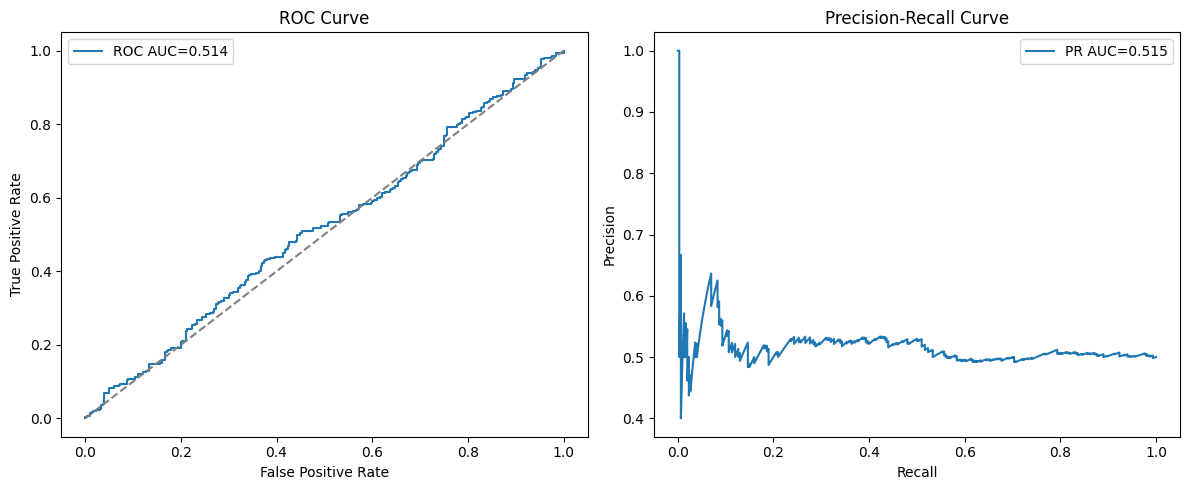

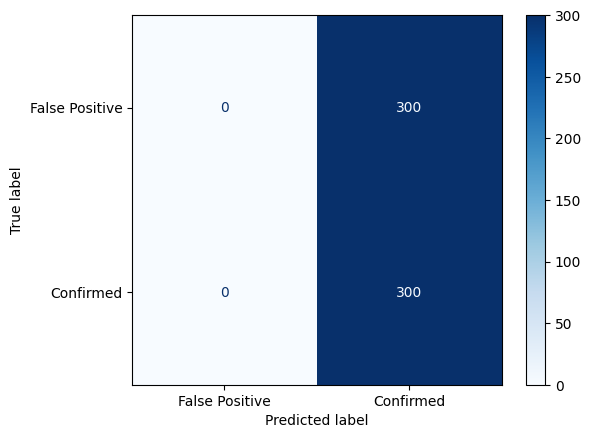

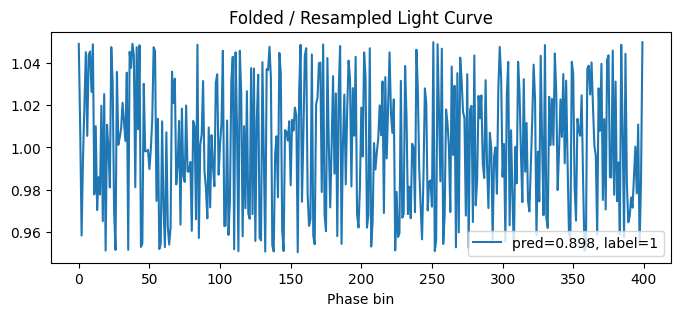

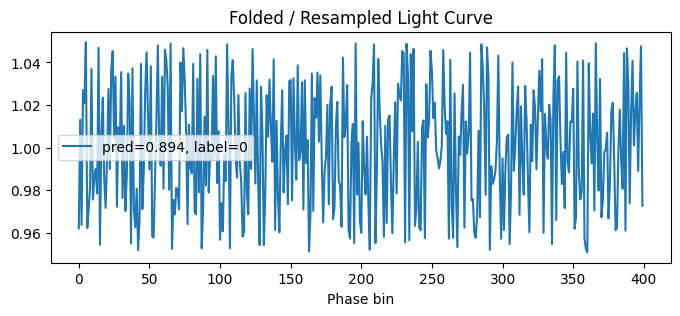

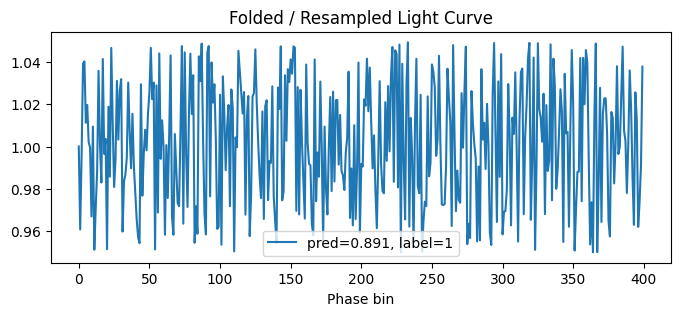

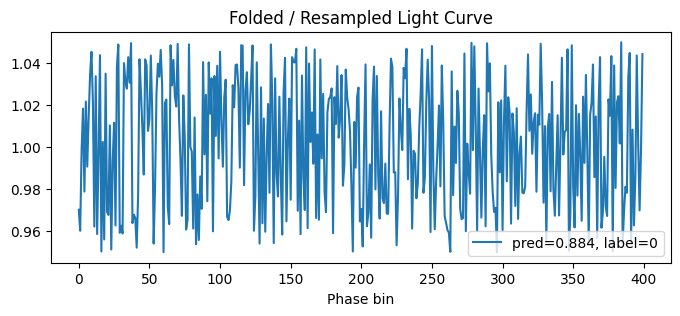

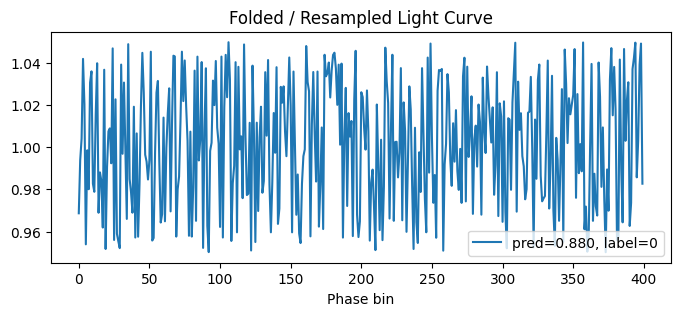

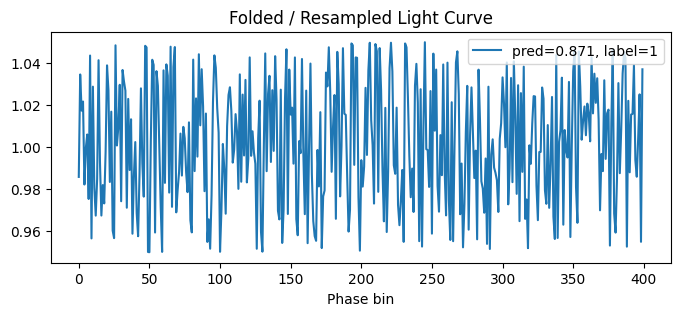

Saved dataset and CNN model.


In [60]:
# Evaluation, ROC, PR, and Confusion Matrix
y_pred = model.predict(X_test).ravel()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.3f}')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR AUC={pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['False Positive', 'Confirmed'])
disp.plot(cmap='Blues')
plt.show()

# Visualize top predicted planets
for i in np.argsort(y_pred)[-6:][::-1]:
    plt.figure(figsize=(8, 3))
    plt.plot(X_test[i].squeeze(), label=f'pred={y_pred[i]:.3f}, label={y_test[i]}')
    plt.title('Folded / Resampled Light Curve')
    plt.xlabel('Phase bin')
    plt.legend()
    plt.show()

# Save preprocessed arrays and model
np.savez_compressed('kepler_200_dataset.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
model.save('cnn_kepler_200_v2.keras')
print('Saved dataset and CNN model.')